In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn import svm
from sklearn.model_selection import GridSearchCV # this will do cross validation
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_kddcup99 # import the dataset
dataset = fetch_kddcup99(as_frame=True) # fetch the data set, 10% of the data by default

# Extract as pandas DataFrame
df = dataset.frame
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels
0,0,b'tcp',b'http',b'SF',181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,b'normal.'
1,0,b'tcp',b'http',b'SF',239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,b'normal.'
2,0,b'tcp',b'http',b'SF',235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,b'normal.'
3,0,b'tcp',b'http',b'SF',219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,b'normal.'
4,0,b'tcp',b'http',b'SF',217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,b'normal.'


In [2]:
# see what the data looks like

print(len(df['labels'].unique()))
print(df['labels'].unique())
print(df['labels'].value_counts())

23
[b'normal.' b'buffer_overflow.' b'loadmodule.' b'perl.' b'neptune.'
 b'smurf.' b'guess_passwd.' b'pod.' b'teardrop.' b'portsweep.' b'ipsweep.'
 b'land.' b'ftp_write.' b'back.' b'imap.' b'satan.' b'phf.' b'nmap.'
 b'multihop.' b'warezmaster.' b'warezclient.' b'spy.' b'rootkit.']
labels
b'smurf.'              280790
b'neptune.'            107201
b'normal.'              97278
b'back.'                 2203
b'satan.'                1589
b'ipsweep.'              1247
b'portsweep.'            1040
b'warezclient.'          1020
b'teardrop.'              979
b'pod.'                   264
b'nmap.'                  231
b'guess_passwd.'           53
b'buffer_overflow.'        30
b'land.'                   21
b'warezmaster.'            20
b'imap.'                   12
b'rootkit.'                10
b'loadmodule.'              9
b'ftp_write.'               8
b'multihop.'                7
b'phf.'                     4
b'perl.'                    3
b'spy.'                     2
Name: count, dtype: i

In [3]:
# Data preprocessing

# convert byte strings into strings

df = df.map(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

# try to convert columns to numeric where possible
df = df.apply(pd.to_numeric, errors='ignore')

print(df.info())

dos_attacks = ['back.', 'land.', 'neptune.', 'pod.', 'smurf.', 'teardrop.']

# separate the features from the labels
X = df.drop(columns = ['labels'])

# Define the target y based being DoS or not

y = df['labels'].apply(lambda x: 1 if x in dos_attacks else 0)

print(y.value_counts())

# split the dataset into 80% training and 20% test using the stratify parameter
# to preserve proportions of non-dos and dos and fixed random_state so we get
# consistent results at each run

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



/tmp/ipython-input-628362602.py:8: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494021 entries, 0 to 494020
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     494021 non-null  int64  
 1   protocol_type                494021 non-null  object 
 2   service                      494021 non-null  object 
 3   flag                         494021 non-null  object 
 4   src_bytes                    494021 non-null  int64  
 5   dst_bytes                    494021 non-null  int64  
 6   land                         494021 non-null  int64  
 7   wrong_fragment               494021 non-null  int64  
 8   urgent                       494021 non-null  int64  
 9   hot                          494021 non-null  int64  
 10  num_failed_logins            494021 non-null  int64  
 11  logged_in                    494021 non-null  int64  
 12  num_compromised              494021 non-null  int64  
 13 

Since the dataset is imbalanced and has too many example of non-dos attacks, we will undersample the training dataset to make it more balanced. After that we will reduce the size of the training dataset. Finally, since the dataset contains three categorical columns (protocol_type, service and flag), we will use OneHotEncoder to convert them into binary columns.

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler

# undersample only the training dataset
rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

# Reduce size for SVM speed
X_train_res, _, y_train_res, _ = train_test_split(
    X_train_res, y_train_res, train_size=0.1, stratify=y_train_res, random_state=42
)
categorical = ['protocol_type', 'service', 'flag']
numeric = [col for col in X_train.columns if col not in categorical]

# Transform categorical columns via OneHotEncoder and numerical via MinMaxScaler
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical),
        ('num', MinMaxScaler(), numeric)
    ]
)

# fit on training, transform both
X_train_ready = preprocessor.fit_transform(X_train_res)
X_test_ready  = preprocessor.transform(X_test)

First, traing the model using the 'linear' kernel , which is for lineary separable data. It will behave similarly to logistic regression where we can see the coefficients

In [8]:
# Train using linear kernel
C = 0.1  # SVM regularization parameter
# record start and end traing times so we can compare the kernels
start = time.time()
lin_svc = svm.SVC(kernel='linear', C=C).fit(X_train_ready, y_train_res)
end = time.time()
print(f"Linear training time: {end - start:.2f} seconds")


Linear training time: 0.27 seconds


Evaluate the model on the test data

In [9]:
y_pred = lin_svc.predict(X_test_ready)
print("CONFUSION MATRIX: ")
print(confusion_matrix(y_test, y_pred))
#calculate accuracy
accuracy = lin_svc.score(X_train_ready, y_train_res)
print(f"Training accuracy: {accuracy:.4f}")

# get the test accuracy
test_accuracy = lin_svc.score(X_test_ready, y_test)
print(f"Testing accuracy: {test_accuracy:.4f}")
# coefficients
coefs = lin_svc.coef_.ravel()
# print(coefs)
# get feature names back from preprocessor
feature_names = preprocessor.get_feature_names_out()
print("Length of coefficients: ", len(coefs), "Number of features: ", len(feature_names))


CONFUSION MATRIX: 
[[20504     9]
 [  514 77778]]
Training accuracy: 0.9969
Testing accuracy: 0.9947
Length of coefficients:  107 Number of features:  107


We have additional features (columns) due to OneHotEncoding. Totla number of coefficients is 107 and features is also 107. The coefficients with highest absolute value are the most important.

In [10]:
# Find the index of the maximum coefficient
# Top 3 features by absolute coefficient
top2_idx = np.argsort(np.abs(coefs))[-3:]
print("Top 3 features:", feature_names[top2_idx], "with weights:", coefs[top2_idx])

Top 3 features: ['num__dst_host_diff_srv_rate' 'num__diff_srv_rate' 'num__wrong_fragment'] with weights: [-1.17042399 -1.27266786  1.63333333]


**Interpretation of results using the linear kernel**

The most important features according to this model are "diff_serv_rate" and wrong_fragment. diff_srv_rate is he percentage of connections made to different services within a two-second window. A low diff_srv_rate indicates that a connection is targeting the same service repeatedly, which could be a sign of a Denial of Service attack. Conversely, a high value is more likely to point to a probing attack as the attacker is scanning different services. Therefore, the negative coefficient makes sense. The second feature - wrong_fragment - points to attacker sending corrupted or malformed network packet fragments. This could crash or overload the receiver, hence - denial of service.

In [11]:
# Train using the rbf (Radial Basis Function) kernel

rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C).fit(X_train_ready, y_train_res)
start = time.time()
rbf_svc.fit(X_train_ready, y_train_res)
end = time.time()
print(f"RBF training time: {end - start:.2f} seconds")

# run on the test data
y_pred = rbf_svc.predict(X_test_ready)
print("CONFUSION MATRIX: ")
print(confusion_matrix(y_test, y_pred))
#calculate accuracy
accuracy = rbf_svc.score(X_train_ready, y_train_res)
print(f"Training accuracy: {accuracy:.4f}")

# get the test accuracy
test_accuracy = rbf_svc.score(X_test_ready, y_test)
print(f"Testing accuracy: {test_accuracy:.4f}")

RBF training time: 0.55 seconds
CONFUSION MATRIX: 
[[20508     5]
 [  733 77559]]
Training accuracy: 0.9958
Testing accuracy: 0.9925


In [12]:
# Train using the poly (Polynomial) kernel

poly_svc = svm.SVC(kernel='poly', degree=3, C=C).fit(X_train_ready, y_train_res)
start = time.time()
poly_svc.fit(X_train_ready, y_train_res)
end = time.time()
print(f"Polynomial training time: {end - start:.2f} seconds")
# run on the test data
y_pred = poly_svc.predict(X_test_ready)
print("CONFUSION MATRIX: ")
print(confusion_matrix(y_test, y_pred))
#calculate accuracy
accuracy = poly_svc.score(X_train_ready, y_train_res)
print(f"Training accuracy: {accuracy:.4f}")

# get the test accuracy
test_accuracy = poly_svc.score(X_test_ready, y_test)
print(f"Testing accuracy: {test_accuracy:.4f}")

Polynomial training time: 0.59 seconds
CONFUSION MATRIX: 
[[20507     6]
 [  714 77578]]
Training accuracy: 0.9959
Testing accuracy: 0.9927


In [13]:
# Train using the sigmoid kernel

sigmoid_svc = svm.SVC(kernel='sigmoid',C=C).fit(X_train_ready, y_train_res)
start= time.time()
sigmoid_svc.fit(X_train_ready, y_train_res)
end = time.time()
print(f"Sigmoid training time: {end - start:.2f} seconds")
# run on the test data
y_pred = sigmoid_svc.predict(X_test_ready)
print("CONFUSION MATRIX: ")
print(confusion_matrix(y_test, y_pred))
#calculate accuracy
accuracy = sigmoid_svc.score(X_train_ready, y_train_res)
print(f"Training accuracy: {accuracy:.4f}")

# get the test accuracy
test_accuracy = sigmoid_svc.score(X_test_ready, y_test)
print(f"Testing accuracy: {test_accuracy:.4f}")

Sigmoid training time: 4.99 seconds
CONFUSION MATRIX: 
[[20068   445]
 [  648 77644]]
Training accuracy: 0.9851
Testing accuracy: 0.9889


## Compare results for different kernels

The linear kernel is the fastest and simplest and is meant to be used with data that is linearly separable. The cons of using it is that if the data is not linearly separable, it will produce inaccurate results. The Radial Basis Function (RBF) kernel is a good default choice for many non-linear problems, it is slightly slower than the linear, but has good accuracy on our case. The polynomial kernel is best suited for data that has ploynomial relationship. In our case it has similar accuracy and speed to the linear kernel. The sigmoid kernel was the slowest and least accurate, though it still achieved pretty good training and testing accuracy. It is best suited for data with sigmoid shape distribution and needs careful tuning of the parameters.



## Train on 2 Features

For this part, I will select count (number of connections to the same host as the current connection within the past two sec) and diff_srv_rate (the num__ prefix was added by the encoder). Diff_srv_rate is usually negatively tied to DoS attack, i.e. if it is a high number it is more likely scanning, i.e. Probe, so we will expect it to have a negative coefficient.

In [21]:
## Select the two features that we will train on from the original data

X = df[['count', 'diff_srv_rate']]
print(X.head())

#split the dataset into 80% training and 20% test using the stratify parameter to preserve proportions of non-dos and dos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# undersample only the training dataset
rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

# Reduce size for SVM speed
X_train_res, _, y_train_res, _ = train_test_split(
    X_train_res, y_train_res, train_size=0.1, stratify=y_train_res, random_state=42
)

# now we only have numerical columns, which we scale
scaler = MinMaxScaler()
X_train_ready = scaler.fit_transform(X_train_res)
X_test_ready = scaler.transform(X_test)



   count  diff_srv_rate
0      8            0.0
1      8            0.0
2      8            0.0
3      6            0.0
4      6            0.0


In [22]:
# Train with 2 features using linear kernel
  # SVM regularization parameter
# record start and end traing times so we can compare the kernels

C = 1.0
start = time.time()
lin_svc = svm.SVC(kernel='linear', C=C).fit(X_train_ready, y_train_res)
end = time.time()
print(f"Linear 2-feature training time: {end - start:.2f} seconds")

# Evaluate on test data
y_pred = lin_svc.predict(X_test_ready)
print("CONFUSION MATRIX: ")
print(confusion_matrix(y_test, y_pred))
#calculate accuracy
accuracy = lin_svc.score(X_train_ready, y_train_res)
print(f"Training accuracy: {accuracy:.4f}")

# get the test accuracy
test_accuracy = lin_svc.score(X_test_ready, y_test)
print(f"Testing accuracy: {test_accuracy:.4f}")
# coefficients
coefs = lin_svc.coef_.ravel()

print("Coefficients: ", coefs)


Linear 2-feature training time: 0.33 seconds
CONFUSION MATRIX: 
[[20306   207]
 [ 1360 76932]]
Training accuracy: 0.9874
Testing accuracy: 0.9841
Coefficients:  [ 13.67913994 -13.14173343]


In [23]:
# Train with 2 features using RBF kernel
rbf_svc = svm.SVC(kernel='rbf', gamma=0.01, C=C).fit(X_train_ready, y_train_res)
start = time.time()
rbf_svc.fit(X_train_ready, y_train_res)
end = time.time()
print(f"RBF 2-feature training time: {end - start:.2f} seconds")

# run on the test data
y_pred = rbf_svc.predict(X_test_ready)
print("CONFUSION MATRIX: ")
print(confusion_matrix(y_test, y_pred))
#calculate accuracy
accuracy = rbf_svc.score(X_train_ready, y_train_res)
print(f"Training accuracy: {accuracy:.4f}")

# get the test accuracy
test_accuracy = rbf_svc.score(X_test_ready, y_test)
print(f"Testing accuracy: {test_accuracy:.4f}")


RBF 2-feature training time: 1.56 seconds
CONFUSION MATRIX: 
[[20134   379]
 [ 5298 72994]]
Training accuracy: 0.9553
Testing accuracy: 0.9425


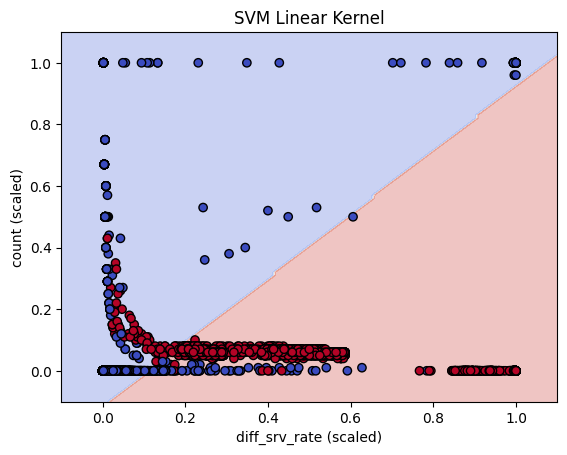

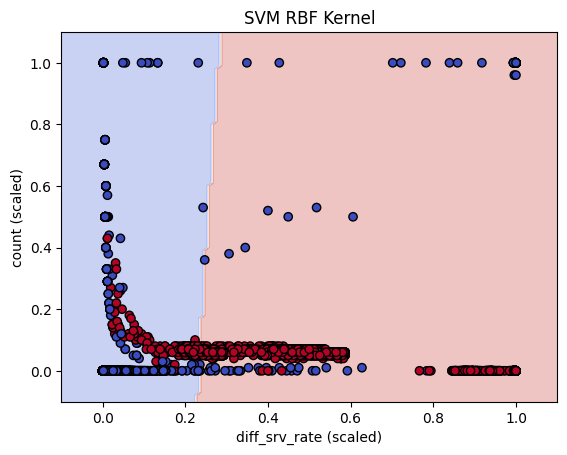

In [24]:
# plot decision boundary

import matplotlib.pyplot as plt

def plot_decision_boundary(clf, X, y, title):
    h = 0.01  # step size in the mesh

    # create a mesh to plot in
    x_min, x_max = X_train_ready[:, 0].min() - 0.1, X_train_ready[:, 0].max() + 0.1
    y_min, y_max = X_train_ready[:, 1].min() - 0.1, X_train_ready[:, 1].max() + 0.1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # predict class for each point in the mesh
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)

    # Plot decision regions
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.coolwarm)
    plt.xlabel('diff_srv_rate (scaled)')
    plt.ylabel('count (scaled)')
    plt.title(title)
    plt.show()

# plot Linear
plot_decision_boundary(lin_svc, X_train_ready, y_train_res, "SVM Linear Kernel")

# plot RBF
plot_decision_boundary(rbf_svc, X_train_ready, y_train_res, "SVM RBF Kernel")


**Conclusion:** In the 2-feature case, the linear model performed better. Probably the parameters C and gamma for RBF need to be better tuned using cross-validation and GridSearchCV, however this can be computationally expensive.